# E-commerce Text Classification

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.preprocessing import LabelEncoder


## Reading and Analysing the dataset

In [2]:
df = pd.read_csv('ecommerceDataset.csv',usecols=['Class','Text'])
df.head()

,Class,Text
0,Books,Inner Engineering: A Yogi's Guide to Joy About...
1,Books,Muslims and Missionaries in Pre-Mutiny India
2,Books,The PCOD - Thyroid Book - Compiled From Women ...
3,Books,The Monk Who Sold His Ferrari Review Everyone ...
4,Books,The Secret of Secrets: The Secrets of the Gold...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50425 entries, 0 to 50424
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Class   50425 non-null  object
 1   Text    50424 non-null  object
dtypes: object(2)
memory usage: 788.0+ KB


We observe that there is a null value in Text column. Let's drop it

In [4]:
# Dropping null values
df.dropna(inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 50424 entries, 0 to 50424
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Class   50424 non-null  object
 1   Text    50424 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [5]:
# Checking for duplicates
df.duplicated().sum()

22622

We observe that there are 22.6K  duplicated values, which have to be removed

In [6]:
df.drop_duplicates(keep='first',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27802 entries, 0 to 50410
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Class   27802 non-null  object
 1   Text    27802 non-null  object
dtypes: object(2)
memory usage: 651.6+ KB


In [7]:
# Checking class distribution
df['Class'].value_counts()/len(df)

Household                 0.379973
Books                     0.225020
Clothing & Accessories    0.204086
Electronics               0.190922
Name: Class, dtype: float64

There is a slight imbalance in the dataset, with majority of data belonging to Household category

In [8]:
#Let's check the min, max and median text length
min_length = df['Text'].str.len().min()
max_length = df['Text'].str.len().max()
avg_length = df['Text'].str.len().mean()
median_length = df['Text'].str.len().median()

print('Minimum: ',min_length)
print('Maximum: ',max_length)
print('Average: ',avg_length)
print('Median: ',median_length)

Minimum:  4
Maximum:  32493
Average:  698.1056039133875
Median:  473.0


We see that the text length varies from a character count of 4  to 32,493. This might change after removing stopwords. Let's limit the text length to 150 words.

## Train-Test split

In [9]:
y = df.pop('Class')
X=df

In [10]:
#Since the class distribution is imbalanced, we are doing a stratified shuffle split
sss= StratifiedShuffleSplit(n_splits=1, test_size=.3,random_state=100)
for train_index,test_index in sss.split(X,y):
    X_train,X_test =X.iloc[train_index],X.iloc[test_index]
    y_train,y_test=y.iloc[train_index],y.iloc[test_index]

##  Preprocessing

In [11]:
# Preprocessing Text
def text_preprocess(text):
    '''This function will change the case to lower, remove the stopwords, numbers & punctuations and perform stemming.
      Further, the text size is also limited to 100 words'''
        
    txt = text.lower()
    
    txt = re.sub('[^a-zA-Z\s]','',txt)
    
    stop_word = set(stopwords.words('english'))
    lemma =  WordNetLemmatizer()
    txt =' '.join([lemma.lemmatize(word) for word in txt.split() if word not in stop_word][:150]) 
    
    return txt

In [12]:
X_train['Text'] =X_train['Text'].apply(text_preprocess)

C:\Users\lenov\AppData\Local\Temp\ipykernel_22844\531990991.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Text'] =X_train['Text'].apply(text_preprocess)


In [13]:
# TF IDF
tf_idf = TfidfVectorizer(ngram_range=(1,2),min_df=.01,max_df=.85,sublinear_tf=True)
X_train_tfidf = tf_idf.fit_transform(X_train['Text'])
len(tf_idf.get_feature_names_out())

933

In [14]:
#Encoding Target variable
le=LabelEncoder()
y_train_label=le.fit_transform(y_train)


In [15]:
# let's look at the label assigned for each class
for i in range(4):
    print (i, le.inverse_transform([i]))

0 ['Books']
1 ['Clothing & Accessories']
2 ['Electronics']
3 ['Household']


## Model Building

In [16]:
xgb = XGBClassifier(n_estimators=50,max_depth=4,n_jobs=-1)
model = xgb.fit(X_train_tfidf,y_train_label)

In [17]:
y_train_pred= model.predict(X_train_tfidf)

In [18]:
report = classification_report(y_train_label,y_train_pred)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      4379
           1       0.96      0.95      0.95      3972
           2       0.95      0.84      0.89      3715
           3       0.90      0.95      0.92      7395

    accuracy                           0.92     19461
   macro avg       0.93      0.92      0.92     19461
weighted avg       0.93      0.92      0.92     19461



## Model evaluation

In [19]:
X_test['Text_prep']=X_test['Text'].apply(text_preprocess)
X_test_tfidf = tf_idf.transform(X_test['Text_prep'])

C:\Users\lenov\AppData\Local\Temp\ipykernel_22844\2510339994.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Text_prep']=X_test['Text'].apply(text_preprocess)


In [20]:
# Target encoding
y_test_label = le.transform(y_test)

In [21]:
# Evaluation on test set
y_pred = model.predict(X_test_tfidf)
report_test = classification_report(y_test_label,y_pred)
print(report_test)

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1877
           1       0.94      0.93      0.94      1702
           2       0.93      0.84      0.89      1593
           3       0.88      0.93      0.91      3169

    accuracy                           0.91      8341
   macro avg       0.92      0.90      0.91      8341
weighted avg       0.91      0.91      0.91      8341



The model performs well on both training and test data and weighted f1 score is .91

In [22]:
#Let's plot the confusion matrix
conf=confusion_matrix(y_test_label,y_pred)

<AxesSubplot: >

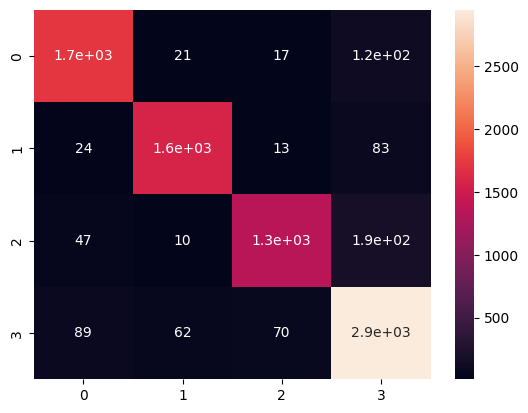

In [23]:
import seaborn as sns
sns.heatmap(conf,annot=True)

### Testing on random data

In [26]:
test_input=[(X_test['Text'][24239] , y_test[24239]),(X_test['Text'][28563] , y_test[28563]),(X_test['Text'][39530] , y_test[39530]),(X_test['Text'][46504] , y_test[46504])]



In [27]:
txt=[]
for i in range(len(test_input)):
    txt.append(text_preprocess(test_input[i][0]))

txt_tfidf= tf_idf.transform(txt)

In [28]:
pred = model.predict(txt_tfidf)
for i in range(len(test_input)):
    print("Input: ", test_input[i][0][:200],'...')  # only first 200 characters are printed
    print("Predicted class: ",le.inverse_transform([pred[i]]) ," Actual class: ", test_input[i][1],'\n\n')

Input:  Black & Decker KW712 650-watts Wood Planer ...
Predicted class:  ['Household']  Actual class:  Household 


Input:  Acupuncture - Oru Arimugam Guide book that provides introduction to everything about Acupuncture ...
Predicted class:  ['Books']  Actual class:  Books 


Input:  Khushal K Women's Cotton Printed Jacket Kurta With Palazzo Pant Set Impress Everyone With Your Stunning Traditional Look By Wearing This Beautiful Printed Cotton Jacket & Inner Kurta With Printed Cott ...
Predicted class:  ['Clothing & Accessories']  Actual class:  Clothing & Accessories 


Input:  CamArmour Flexible Octopus Foldable Tripod for Camera, DSLR and Smartphones with Universal Mobile Attachment(White & Black) ★ Want to own a tripod for your camera but within the range of your pocket.. ...
Predicted class:  ['Electronics']  Actual class:  Electronics 




We see that all the text inputs are correctly classified